In [1]:
import sys
import os

if sys.version_info[0] < 3:
  print('[ERROR] You need to run this with Python 3.')
  raise AssertionError

In [2]:
import numpy as np

import functools
import itertools
import toolz

from emtf_algos import *
from emtf_logger import get_logger
from emtf_colormap import get_colormap

In [3]:
# Set random seed
np.random.seed(2027)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as k_layers
from tensorflow.keras import backend as k_backend
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
tf.random.set_seed(2027)

#import numba
#from numba import njit, vectorize
import dask
import dask.array as da

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(tf.config.list_physical_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))
#logger.info('Using numba      : {0}'.format(numba.__version__))
logger.info('Using dask       : {0}'.format(dask.__version__))

assert k_backend.backend() == 'tensorflow'
assert k_backend.image_data_format() == 'channels_last'

%matplotlib inline

[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) [GCC 7.3.0]
[INFO    ] Using numpy      : 1.19.2
[INFO    ] Using tensorflow : 2.4.1
[INFO    ] Using keras      : 2.4.0
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[INFO    ] Using matplotlib : 3.3.2
[INFO    ] Using dask       : 2021.01.1


In [4]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

# masked array filling value
ma_fill_value = 999999

#maxevents = 10
maxevents = -1

workers = 1
#workers = 8

# Input files
features_fname = 'features_merge.h5'


# Scheduler
dask.config.set(scheduler='threads', num_workers=workers)

# Styling
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
logger.info('.. maxevents        : {0}'.format(maxevents))
logger.info('.. workers          : {0}'.format(workers))

[INFO    ] Processing zone 0 timezone 0
[INFO    ] .. maxevents        : -1
[INFO    ] .. workers          : 1


In [5]:
# Import ML stuff

# tensorflow-probability
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

## tensorflow-addons
#import tensorflow_addons as tfa

# tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

import pandas as pd
import seaborn as sns

# Custom layers
from k_preprocessing_normalization import Normalization as MyNormalization
from k_layers_sanitization import Sanitization as MySanitization
from k_layers_sampling import Sampling as MySampling
from k_losses_huber import Huber as MyHuber
from k_losses_logcosh import LogCosh as MyLogCosh
from k_optimizers_exponential_decay import ExponentialDecay as MyExponentialDecay

# Do the following to reload the custom layers
#   %load_ext autoreload
#   %autoreload 2

### Load data

In [6]:
import h5py
file_handles = []

def load_features():
  fname = features_fname
  logger.info('Loading from {0}'.format(fname))
  loaded = h5py.File(fname, 'r')
  file_handles.append(loaded)
  features = da.from_array(loaded['features'])
  truths = da.from_array(loaded['truths'])

  features = np.array(features)  # lazy no more
  truths = np.array(truths)  # lazy no more
  logger.info('features: {0} truths: {1}'.format(features.shape, truths.shape))
  logger.info('features: {0} truths: {1}'.format(features.dtype, truths.dtype))
  return features, truths

In [7]:
# Load features and truths
features, truths = load_features()

for file_handle in file_handles:  # close files
  file_handle.close()

[INFO    ] Loading from features_merge.h5
[INFO    ] features: (1590732, 40) truths: (1590732, 9)
[INFO    ] features: int32 truths: float32


In [8]:
def train_test_split(*arrays, test_size=0.4, shuffle=True):
  assert(len(arrays) >= 2)
  num_samples = arrays[0].shape[0]
  num_train_samples = int(np.ceil(num_samples * (1. - test_size)))
  num_test_samples = num_samples - num_train_samples
  index_array = np.arange(num_samples)
  if shuffle:
    np.random.shuffle(index_array)
  index_array_train, index_array_test = index_array[:num_train_samples], index_array[num_train_samples:]

  train_test_pairs = (
      (arr[index_array_train], arr[index_array_test])
      for arr in arrays
  )
  return tuple(itertools.chain.from_iterable(train_test_pairs))

def cast_x_to_fixed_point(x, mask):
  # Convert from integer to fixed point (but represented as float32).
  # Assume data format ap_fixed<W,I> with W=14, I=4, where W is the total bit width,
  # I is the integer bits, F=W-I is the fractional bits.
  assert (x.dtype == np.int32) and (mask.dtype == np.bool)

  # The following magic constants are derived empirically by inspecting
  #   x_train_1 = x_train.copy()
  #   x_train_1[x_train_mask] = 0
  #   np.round(div_no_nan(np.abs(x_train_1).max(), np.abs(x_train_1).max(axis=0))).astype(np.int32)
  mul_constant = np.array([
      4,   8,  32,  16,   8,   8,  32,  16,   8,   4,  32,   4,
    256, 256, 512,1024,1024, 256, 256, 256, 256, 256, 256, 256,
    128, 128, 256, 256, 256,  32, 128, 128, 128, 128, 128, 128,
      1,  16,  16,   1,
  ], dtype=np.int32)
  div_constant = np.array(1024, dtype=np.int32)
  assert len(mul_constant) == num_emtf_features

  x_in = x
  x = (x * mul_constant).astype(np.float32) / div_constant
  x[mask] = x_in[mask]
  assert x.dtype == np.float32
  return x

def div_no_nan(x, y):
  x, y = np.asarray(x), np.asarray(y)
  if y.ndim == 0:
    return (x - x) if y == 0 else x
  elif x.ndim == 0:
    mask = (y == 0)
    return x / (y + ((1 - y) * mask))
  else:
    assert x.shape == y.shape
    mask = (y == 0)
    return (x - (x * mask)) / (y + ((1 - y) * mask))

In [9]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(features, truths)

# Convert x_train, x_test to floating-point
ismasked = lambda x: (x == ma_fill_value)
x_train_mask = ismasked(x_train)
x_test_mask = ismasked(x_test)
x_train = cast_x_to_fixed_point(x_train, x_train_mask)
x_test = cast_x_to_fixed_point(x_test, x_test_mask)

# Modify parameter of interest
pt_regr_loss_w = 100
pt_regr_scale_w = 1.
pt_regr_scale_b = np.log(np.expm1(0.0015))
y_train = y_train[:, :1]
y_test = y_test[:, :1]

logger.info('x_train: {0} y_train: {1} x_test: {2} y_test: {3}'.format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))
logger.info('x_train: {0} y_train: {1} x_test: {2} y_test: {3}'.format(x_train.dtype, y_train.dtype, x_test.dtype, y_test.dtype))

[INFO    ] x_train: (954440, 40) y_train: (954440, 1) x_test: (636292, 40) y_test: (636292, 1)
[INFO    ] x_train: float32 y_train: float32 x_test: float32 y_test: float32


### Create model

In [10]:
# Preprocessing layer
preprocessing_layer = MyNormalization(use_bias=False, mask_value=ma_fill_value, name='normalization')
sign_randomization = ((np.random.random_sample(x_train.shape) < 0.5) * 2.) - 1.  # randomize sign so that mean is zero
sign_randomization[x_train_mask] = 1.
preprocessing_layer.adapt(x_train * sign_randomization)
#print(preprocessing_layer.mean.numpy())
#print(preprocessing_layer.variance.numpy())

#y_preprocessing_layer = MyNormalization()
#y_preprocessing_layer.adapt(y_train)
#print(y_preprocessing_layer.mean.numpy())
#print(y_preprocessing_layer.variance.numpy())

# Get rid of mask
#x_train[x_train_mask] = 0
#x_test[x_test_mask] = 0

In [11]:
# Probabilistic layers
prior = tfd.Normal(loc=tf.Variable(0., trainable=False), scale=tf.Variable(1., trainable=False))
probabilistic_layer = tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[..., :1],
        scale=tf.math.maximum(tf.math.softplus((pt_regr_scale_w * t[..., 1:]) + pt_regr_scale_b), k_backend.epsilon())),
    convert_to_tensor_fn=tfd.Distribution.sample,
    activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, use_exact_kl=True, weight=None),
    name='probabilistic_layer')

In [12]:
# Create model
default_learning_rate = 0.001
#learning_rate = 0.0025
learning_rate = 0.005
gradient_clip_norm = 1.
decay_rate = 0.96  # (0.96 ** 100) = 0.01687

epochs = 20 + 100
batch_size = 2048
validation_split = 0.1

def lecun_tanh(x):
  return tf.math.tanh(x * 2./3.) * tf.constant(1./np.tanh(2./3.), dtype='float32')

custom_objects = dict(lecun_tanh=lecun_tanh)
tf.keras.utils.get_custom_objects().update(custom_objects)

def create_lr_schedule():
  decay_steps = int(np.floor(x_train.shape[0] * (1. - validation_split)))
  decay_steps = int(np.ceil(decay_steps / float(batch_size)))
  warmup_steps = decay_steps * 20
  total_steps = decay_steps * epochs
  assert total_steps >= warmup_steps
  final_learning_rate = learning_rate * np.power(decay_rate, np.floor((total_steps - warmup_steps) / float(decay_steps)))
  logger.info('initial_learning_rate: {0:.4e} final_learning_rate: {1:.4e} total_steps: {2}'.format(learning_rate, final_learning_rate, total_steps))

  lr_schedule = MyExponentialDecay(initial_learning_rate=learning_rate, warmup_steps=warmup_steps,
      decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)
  return lr_schedule

def create_model(nodes1=30, nodes2=20, nodes3=10, nodes_in=40, nodes_out=1):
  inputs = tf.keras.Input(shape=(nodes_in,), dtype='float32', name='inputs')

  model = tf.keras.Sequential(name='awesome_model')
  model.add(inputs)

  # Preprocessing
  model.add(preprocessing_layer)
  # Hidden layer 1
  model.add(MySanitization(nodes1, kernel_initializer='lecun_uniform', use_bias=False, activation=None, mask_value=ma_fill_value, name='dense'))
  model.add(k_layers.BatchNormalization(momentum=0.99, epsilon=1e-4, name='batch_normalization'))
  model.add(k_layers.Activation('lecun_tanh', name='activation'))
  # Hidden layer 2
  model.add(k_layers.Dense(nodes2, kernel_initializer='lecun_uniform', use_bias=False, activation=None, name='dense_1'))
  model.add(k_layers.BatchNormalization(momentum=0.99, epsilon=1e-4, name='batch_normalization_1'))
  model.add(k_layers.Activation('lecun_tanh', name='activation_1'))
  # Hidden layer 3
  model.add(k_layers.Dense(nodes3, kernel_initializer='lecun_uniform', use_bias=False, activation=None, name='dense_2'))
  model.add(k_layers.BatchNormalization(momentum=0.99, epsilon=1e-4, name='batch_normalization_2'))
  model.add(k_layers.Activation('lecun_tanh', name='activation_2'))
  # Output layer
  model.add(k_layers.Dense(nodes_out + nodes_out, kernel_initializer='zeros', use_bias=True, activation=None, name='dense_3'))
  model.add(MySampling(scale_w=pt_regr_scale_w, scale_b=pt_regr_scale_b, epsilon=1e-5, kl_weight=1e-3, name='sampling'))
  #model.add(probabilistic_layer)

  # Loss & optimizer
  adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=gradient_clip_norm)
  #nll_loss = lambda y, rv_y: -rv_y.log_prob(y)
  #nll_loss_1 = lambda y, rv_y: -rv_y.log_prob(y) + tf.constant(-0.5 * np.log(2. * np.pi) - np.log(0.0015), dtype='float32')
  #mse_loss = tf.keras.losses.MeanSquaredError()
  #huber_loss = MyHuber()
  #weighted_huber_loss = lambda y_true, y_pred: huber_loss(y_true, y_pred, sample_weight=pt_regr_loss_w)
  logcosh_loss = MyLogCosh()
  weighted_logcosh_loss = lambda y_true, y_pred: logcosh_loss(y_true, y_pred, sample_weight=pt_regr_loss_w)
  model.compile(optimizer=adam, loss=weighted_logcosh_loss)

  # Summary
  model.summary()
  return model

lr_schedule = create_lr_schedule()
model = create_model()

[INFO    ] initial_learning_rate: 5.0000e-03 final_learning_rate: 8.4352e-05 total_steps: 50400


Model: "awesome_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 40)                120       
_________________________________________________________________
dense (Sanitization)         (None, 30)                1200      
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
activation (Activation)      (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                600       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 20)              

### Train model

In [13]:
class LearningRateLogger(tf.keras.callbacks.Callback):
  def __init__(self):
    super(LearningRateLogger, self).__init__()

  def on_epoch_end(self, epoch, logs=None):
    logs = logs or {}
    lr = self.model.optimizer.lr
    if isinstance(lr, MyExponentialDecay):
      lr = lr(self.model.optimizer.iterations)
    else:
      lr = k_backend.get_value(lr)
    logs['lr'] = lr

class ModelTrainer(object):
  def __init__(self, model, log_dir='keras_logs', prefix='', suffix='.log'):
    self.model = model
    self.log_dir = log_dir
    self.prefix = prefix
    self.suffix = suffix

  def fit(self, *args, **kwargs):
    from contextlib import redirect_stdout
    from datetime import datetime
    import os
    import tempfile
    if not os.path.exists(self.log_dir):
      os.makedirs(self.log_dir)
    fd, name = tempfile.mkstemp(prefix=self.prefix, suffix=self.suffix, dir=self.log_dir, text=True)

    start_time = datetime.now()
    logger.info('Begin training ...')

    # Fit
    with os.fdopen(fd, 'w') as f:
      with redirect_stdout(f):
        ret = self.model.fit(*args, **kwargs)

    logger.info('Done training. Time elapsed: {0}'.format(str(datetime.now() - start_time)))
    return ret

class HistoryPlotter(object):
  def __init__(self, history, metric=None):
    self.history = history
    if metric is None:
      metric = 'loss'
    self.metric = metric

  def plot(self):
    train_value = self.history.history[self.metric]
    val_value = self.history.history['val_' + self.metric]
    lr_value = self.history.history['lr']

    tup = (len(self.history.epoch), self.metric, train_value[-1], 'val_' + self.metric, val_value[-1])
    logger.info('Epoch {0:d}/{0:d} - {1}: {2:.4f} - {3}: {4:.4f}'.format(*tup))

    fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)
    ax = axs[0]
    ax.plot(self.history.epoch, lr_value, color='C0')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Learning Rate')
    ax.grid(True)

    ax = axs[1]
    ax.plot(self.history.epoch, train_value, color='C0', label='Train')
    ax.plot(self.history.epoch, val_value, '--', color='C0', label='Val')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(self.metric.replace('_', ' ').title())
    ax.legend(loc='upper right')
    #ax.ylim(0,1)
    ax.grid(True)
    plt.show()

[INFO    ] Begin training ...
[INFO    ] Done training. Time elapsed: 0:03:55.411304
[INFO    ] Epoch 120/120 - loss: 0.0744 - val_loss: 0.0781


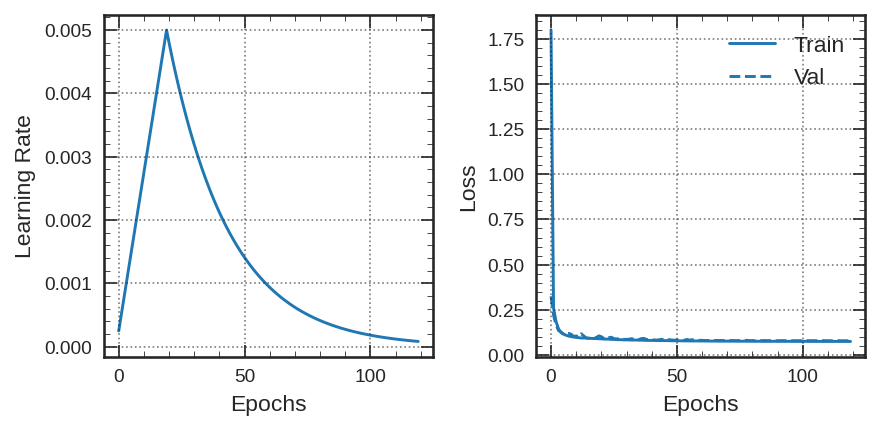

In [14]:
# Train model
callbacks = [LearningRateLogger(),]

history = ModelTrainer(model).fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size,
    validation_split=validation_split, callbacks=callbacks,
    verbose=1)

HistoryPlotter(history).plot()

### Evaluate model

In [15]:
def gaus(x,a,mu,sig):
  return a*np.exp(-0.5*np.square((x-mu)/sig))

def fit_gaus(hist, edges, mu=0., sig=1.):
  from scipy.optimize import curve_fit
  hist = hist.astype(np.float64)
  edges = edges.astype(np.float64)
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[np.max(hist), mu, sig])
  if not np.isfinite(pcov).all():
    raise Exception('Fit has failed to converge.')
  return popt

def mean_squared_error(y_true, y_pred):
  # K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
  return tf.keras.losses.mean_squared_error(y_true, y_pred).numpy()

def mean_absolute_error(y_true, y_pred):
  # K.mean(math_ops.abs(y_pred - y_true), axis=-1)
  return tf.keras.losses.mean_absolute_error(y_true, y_pred).numpy()

def median_absolute_deviation(y_true, y_pred):
  scale = 0.6744897501960817  # special.ndtri(0.75)
  return np.median(np.abs(y_pred - y_true), axis=-1) / scale

In [16]:
# Make predictions
y_test_true = y_test.copy()
y_test_pred = model.predict(x_test, batch_size=8192)

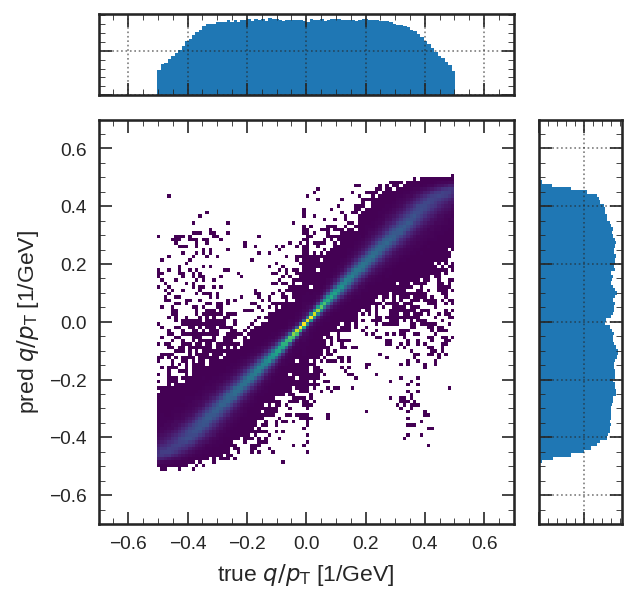

In [17]:
# Plot predictions
fig = plt.figure(figsize=(4.5,4.5))

xx = y_test_true
yy = y_test_pred

gs = plt.GridSpec(2, 2, width_ratios=(5,1), height_ratios=(1,5), hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[1,0])
ax_top = fig.add_subplot(gs[0,0], sharex=ax)
ax_right = fig.add_subplot(gs[1,1], sharey=ax)

ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(120,120), range=((-0.7,0.7),(-0.7,0.7)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')
ax_top.hist(np.squeeze(xx), bins=120, range=(-0.7,0.7))
ax_top.tick_params(labelbottom=False, labelleft=False)
ax_right.hist(np.squeeze(yy), bins=120, range=(-0.7,0.7), orientation='horizontal')
ax_right.tick_params(labelbottom=False, labelleft=False)

plt.show()

[INFO    ] (mu, sig, mse, mae, mad): -8.2173e-04, 0.0344, 0.0014, 0.0244, 0.0361
[INFO    ] gaus fit (a, mu, sig): 50370.30, -1.0262e-03, 0.0229
[INFO    ] (mu, sig, mse, mae, mad): -1.5129e-03, 0.0158, 0.0005, 0.0120, 0.0111
[INFO    ] gaus fit (a, mu, sig): 6237.36, -1.6887e-03, 0.0100


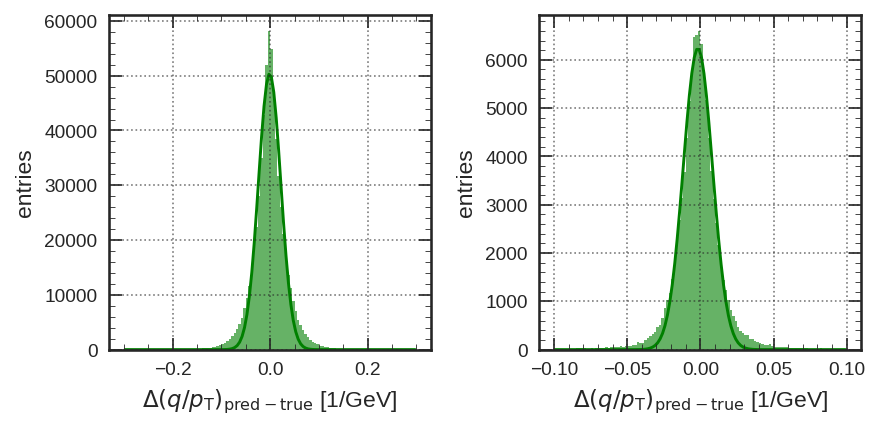

In [18]:
# Plot Delta(q/pt)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = y_test_true
yb = y_test_pred
yy = yb - ya
yy_core = yy[np.abs(yy)<0.3]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', facecolor='g', alpha=0.6)
metrics = yy_core.mean(), yy_core.std(), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('(mu, sig, mse, mae, mad): {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

# Repeat with pt > 14 GeV
sel = (np.abs(1.0/y_test_true) > 14.)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy)<0.3/3]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=120, range=(-0.3/3,0.3/3), histtype='stepfilled', facecolor='g', alpha=0.6)
metrics = yy_core.mean(), yy_core.std(), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('(mu, sig, mse, mae, mad): {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

plt.show()

[INFO    ] (mu, sig, mse, mae, mad): -2.4760e-03, 0.2145, 1865.2327, 0.3816, 0.5657
[INFO    ] gaus fit (a, mu, sig): 45538.52, -1.4367e-02, 0.1259
[INFO    ] (mu, sig, mse, mae, mad): -6.8813e-02, 0.3833, 11481.5459, 1.6273, 0.3282
[INFO    ] gaus fit (a, mu, sig): 3672.21, -1.1123e-01, 0.2334


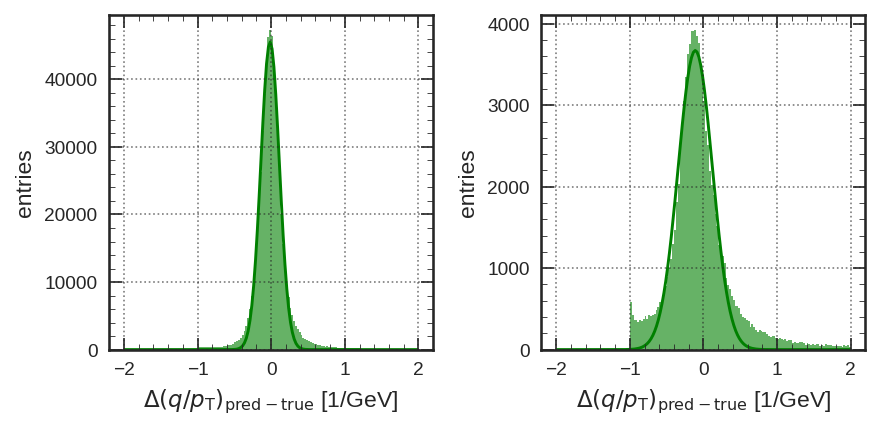

In [19]:
# Plot Delta(q/pt) / pt
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = np.abs(y_test_true/y_test_true)
yb = np.abs(y_test_true/y_test_pred)
yy = yb - ya
yy_core = yy[np.abs(yy)<1.5]

ax = axs[0]
hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
metrics = yy_core.mean(), yy_core.std(), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('(mu, sig, mse, mae, mad): {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/y_test_true) > 14.)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]
yy_core = yy[np.abs(yy)<1.5]

ax = axs[1]
hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
metrics = yy_core.mean(), yy_core.std(), mean_squared_error(ya, yb).mean(), mean_absolute_error(ya, yb).mean(), median_absolute_deviation(ya, yb).mean()
popt = fit_gaus(hist, edges, mu=metrics[0], sig=metrics[1])
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
ax.set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')
ax.set_ylabel(r'entries')
logger.info('(mu, sig, mse, mae, mad): {0:.4e}, {1:.4f}, {2:.4f}, {3:.4f}, {4:.4f}'.format(*metrics))
logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

plt.show()

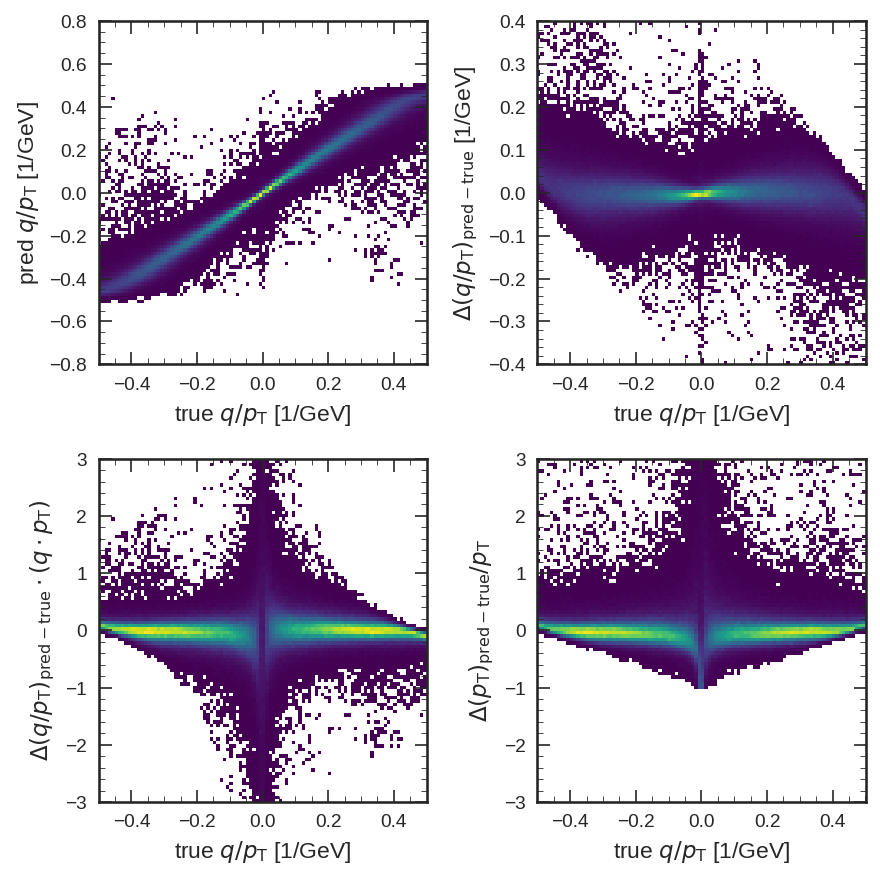

In [20]:
# Plot correlations
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = y_test_true
yy = y_test_pred
ax = axs[0,0]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $q/p_{\mathrm{T}}$ [1/GeV]')

yy = y_test_pred - y_test_true
ax = axs[0,1]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}}$ [1/GeV]')

yy = (y_test_pred - y_test_true)/np.abs(y_test_true)
ax = axs[1,0]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{pred-true}} \cdot (q \cdot p_{\mathrm{T}})$')

yy = np.abs(y_test_true/y_test_pred) - 1
ax = axs[1,1]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')

plt.show()

In [21]:
# Make better resolution plot
# resolution defined as Delta(pt) over pt (no charge), binned in 1/pt (also no charge)
xx = np.abs(y_test_true)
yy = np.abs(y_test_true/y_test_pred) - 1
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xx_pt = np.zeros(nbinsx, dtype=np.float32)
yy_mu = np.zeros(nbinsx, dtype=np.float32)
yy_sig = np.zeros(nbinsx, dtype=np.float32)
yy_tail = np.zeros(nbinsx, dtype=np.float32)
yy_cov = np.zeros(nbinsx, dtype=np.float32)

cache = {}

for i in range(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue

  pt = xx_i.mean()
  pt = 1.0 / pt

  yy_i = yy[inds==i]
  yy_i = yy_i[(-1.0 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = yy_i.mean(), yy_i.std()
  assert(np.abs(mu) < 1.0)
  assert(np.abs(sig) < 2.0)

  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1])/2
  try:
    popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  except:
    popt = np.array([np.nan, np.nan, np.nan])
  #print(i, len(xx_i), mu, sig, pt, popt)

  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  tail = hist - ydata        # check non-gaussian high tail
  tail[tail < 0] = 0         # ignore hist < gaus
  tail[xdata < popt[2]] = 0  # ignore low tail
  tail = tail.sum() / len(xx_i)

  pct = np.percentile(yy_i, (100 - 90), overwrite_input=True)  # find 10-percentile
  cov = -1 * pct / popt[2]
  # If truly gaussian, the required number of sigmas is 1.28155 for 90% coverage
  #print(scipy.special.erfinv(0.80) * np.sqrt(2))

  xx_pt[i] = pt
  yy_mu[i] = popt[1]
  yy_sig[i] = popt[2]
  yy_tail[i] = tail
  yy_cov[i] = cov

  if 14. < pt < 15.:
    cache[0] = (i, xx_i, yy_i)
  elif 20. < pt < 22.:
    cache[1] = (i, xx_i, yy_i)
  elif 25. < pt < 28.:
    cache[2] = (i, xx_i, yy_i)
  elif 28. < pt < 33.:
    cache[3] = (i, xx_i, yy_i)

[INFO    ] gaus fit (a, mu, sig): 390.20, -7.2371e-02, -0.1732
[INFO    ] gaus fit (a, mu, sig): 332.54, -9.4263e-02, -0.1948
[INFO    ] gaus fit (a, mu, sig): 307.71, -1.0765e-01, -0.2046
[INFO    ] gaus fit (a, mu, sig): 280.01, -1.2078e-01, -0.2233


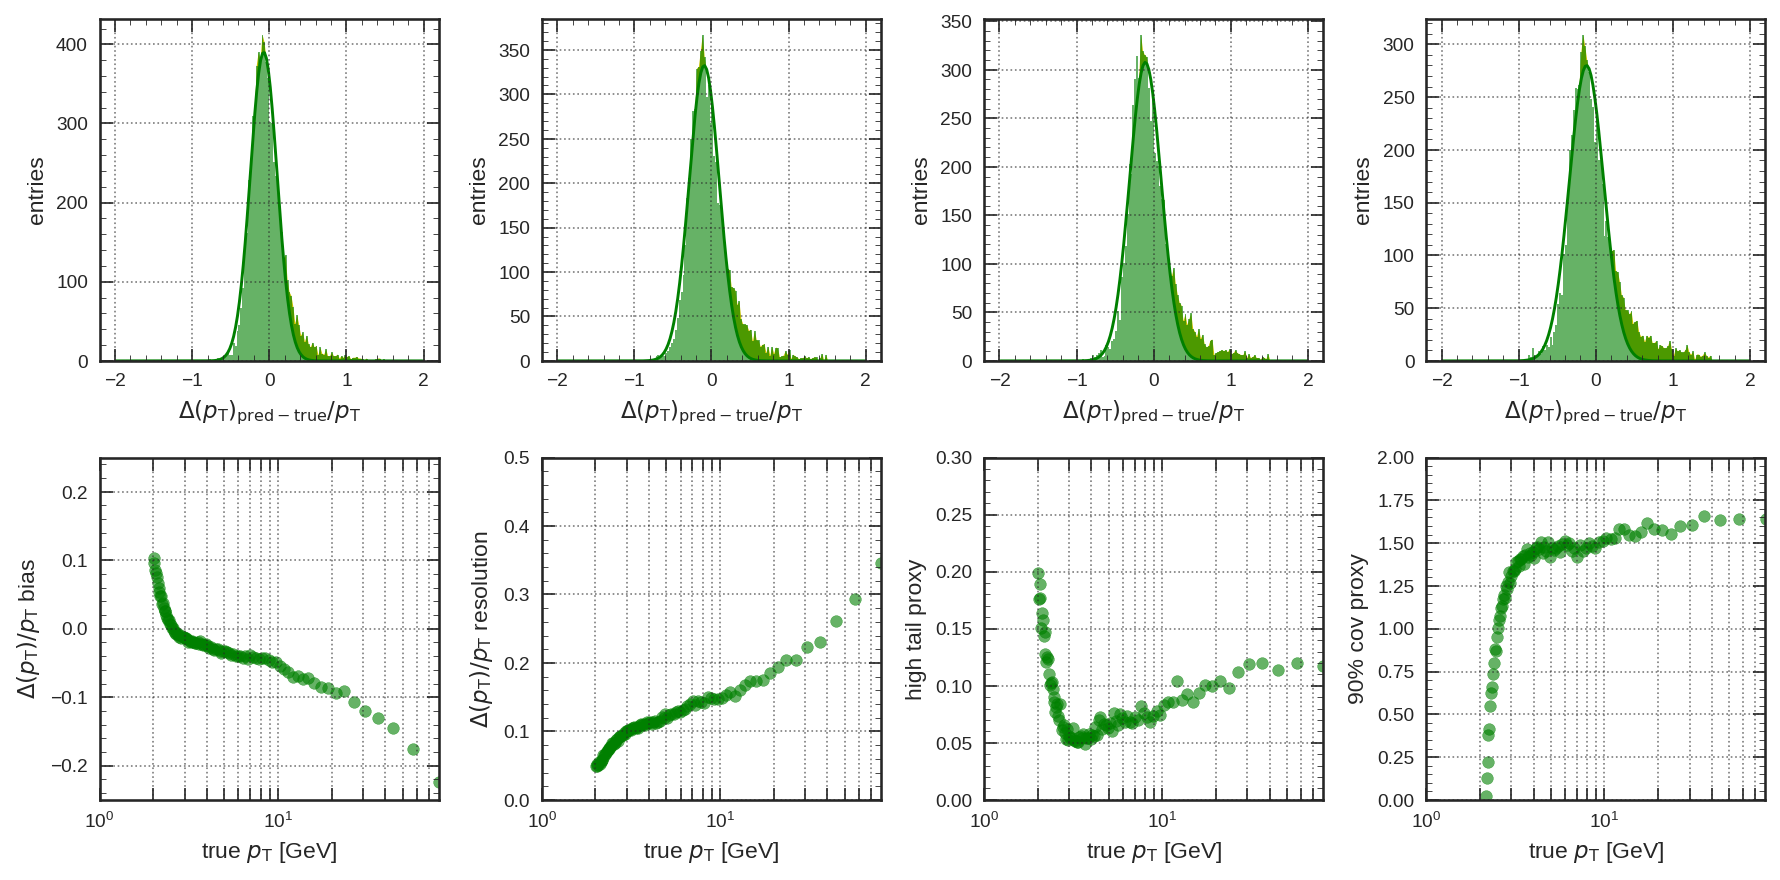

In [22]:
# Make better resolution plot
fig, axs = plt.subplots(2, 4, figsize=(6*2,6), tight_layout=True)

for i in range(4):
  ax = axs[0,i]
  (ii, xx_i, yy_i) = cache[i]  # read from cache
  hist, edges, _ = ax.hist(yy_i, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  popt = fit_gaus(hist, edges, mu=yy_mu[ii], sig=yy_mu[ii])
  xdata = (edges[1:] + edges[:-1])/2
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  tail = hist - ydata        # check non-gaussian high tail
  tail[tail < 0] = 0         # ignore hist < gaus
  tail[xdata < popt[2]] = 0  # ignore low tail
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata + tail, facecolor='y')
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{pred-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')
  logger.info('gaus fit (a, mu, sig): {0:.2f}, {1:.4e}, {2:.4f}'.format(*popt))

cache.clear()

ax = axs[1,0]
ax.scatter(xx_pt, yy_mu, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(-0.25,0.25)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ bias')

ax = axs[1,1]
ax.scatter(xx_pt, yy_sig, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.5)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ resolution')

ax = axs[1,2]
ax.scatter(xx_pt, yy_tail, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.3)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'high tail proxy')

ax = axs[1,3]
ax.scatter(xx_pt, yy_cov, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,2)
ax.set_xscale('log')
ax.set_xticks(list(range(1,10)) + list(range(10,80,10)))
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'90% cov proxy')

plt.show()

In [23]:
# Inspect intermediate layers
extractor_layers = [model.get_layer('normalization').output,
                    model.get_layer('dense').output,
                    model.get_layer('batch_normalization').output,
                    model.get_layer('activation').output,
                    model.get_layer('dense_1').output,
                    model.get_layer('batch_normalization_1').output,
                    model.get_layer('activation_1').output,
                    model.get_layer('dense_2').output,
                    model.get_layer('batch_normalization_2').output,
                    model.get_layer('activation_2').output,
                    model.get_layer('dense_3').output[..., :1],
                    model.get_layer('dense_3').output[..., 1:],]

extractor = keras.Model(inputs=model.inputs,
                        outputs=extractor_layers)

# Run on a subset
num_test_samples = 10000
index_array = np.arange(x_test.shape[0])
shuffle = True
if shuffle:
  np.random.shuffle(index_array)
x_test_1 = x_test[index_array[:num_test_samples]]
y_test_true_1 = y_test_true[index_array[:num_test_samples]]
y_test_pred_1 = y_test_pred[index_array[:num_test_samples]]

extracted = extractor(x_test_1)
extracted = iter(extracted)

extracted_normalization = next(extracted).numpy()
extracted_dense = next(extracted).numpy()
extracted_batch_normalization = next(extracted).numpy()
extracted_activation = next(extracted).numpy()
extracted_dense_1 = next(extracted).numpy()
extracted_batch_normalization_1 = next(extracted).numpy()
extracted_activation_1 = next(extracted).numpy()
extracted_dense_2 = next(extracted).numpy()
extracted_batch_normalization_2 = next(extracted).numpy()
extracted_activation_2 = next(extracted).numpy()
extracted_dense_3_loc = next(extracted).numpy()
extracted_dense_3_scale = next(extracted).numpy()

# Get rid of mask
extracted_normalization_mask = ismasked(extracted_normalization)
extracted_normalization[extracted_normalization_mask] = 0

# Get y_test_pred_scale_logit, y_test_pred_scale
np_softplus = lambda x: np.log1p(np.exp(x))
y_test_pred_scale_logit = extracted_dense_3_scale
y_test_pred_scale = np_softplus((pt_regr_scale_w * y_test_pred_scale_logit) + pt_regr_scale_b)

[INFO    ] (mu, sig): 0.7533, 0.0108
[INFO    ] (mu, sig): 3.1835e-03, 3.4252e-05


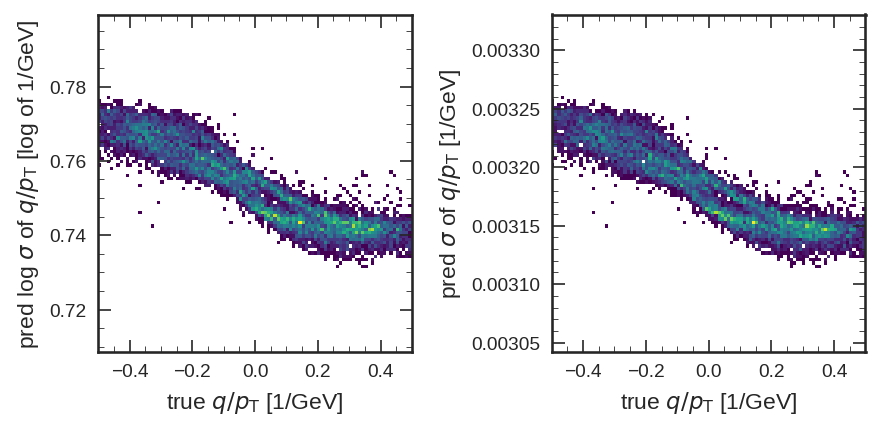

In [24]:
# Plot y_test_pred_scale
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

xx = np.squeeze(y_test_true_1)
yy = np.squeeze(y_test_pred_scale_logit)
yy_min, yy_max = yy.min(), yy.max()
yy_min, yy_max = yy_max - (yy_max - yy_min) * 1.5, yy_min + (yy_max - yy_min) * 1.5

ax = axs[0]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(yy_min,yy_max)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred log $\sigma$ of $q/p_{\mathrm{T}}$ [log of 1/GeV]')
logger.info('(mu, sig): {0:.4f}, {1:.4f}'.format(yy.mean(), yy.std()))

xx = np.squeeze(y_test_true_1)
yy = np.squeeze(y_test_pred_scale)
yy_min, yy_max = yy.min(), yy.max()
yy_min, yy_max = yy_max - (yy_max - yy_min) * 1.5, yy_min + (yy_max - yy_min) * 1.5

ax = axs[1]
ax.hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(yy_min,yy_max)), vmin=1, cmap=cm.viridis_mod)
ax.set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
ax.set_ylabel(r'pred $\sigma$ of $q/p_{\mathrm{T}}$ [1/GeV]')
logger.info('(mu, sig): {0:.4e}, {1:.4e}'.format(yy.mean(), yy.std()))

plt.show()

In [25]:
# Make ridgeplot
def min_max(x):
  return (np.min(x), np.max(x))

def ridgeplot():
  n = xx.shape[1]
  fig, axs = plt.subplots(n, 1, figsize=(6,n*0.25), sharex=True, sharey=False, gridspec_kw=dict(hspace=-0.5))
  pal = sns.cubehelix_palette(n, rot=-.4, light=.7)

  for i in range(n):
    if n == 1:
      ax = axs
    else:
      ax = axs[(n - 1) - i]
    limit = 4
    sns.kdeplot(np.clip(xx[:, i], -limit, limit), bw_adjust=0.25, clip_on=False, fill=True, alpha=1, color=pal[i], ax=ax)
    sns.kdeplot(np.clip(xx[:, i], -limit, limit), bw_adjust=0.25, clip_on=False, lw=1.0, color='w', ax=ax)

    # Remove borders, axis ticks, labels, and make background transparent
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    if i == 0:
      ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
    spines = ['top', 'right', 'left', 'bottom']
    for s in spines:
      if s != 'bottom':
        ax.spines[s].set_visible(False)
    ax.patch.set_alpha(0)

    # Label
    ax.text(0, 0.2, str(i), fontsize=8, ha='right', va='center', transform=ax.transAxes)

  logger.info('(min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

  plt.show()

/blue/avery/jlow/L1MuonTrigger/scratch/2020-00-00-work/miniconda/envs/tf/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/blue/avery/jlow/L1MuonTrigger/scratch/2020-00-00-work/miniconda/envs/tf/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
[INFO    ] (min, max): -7.6946, 13.7562


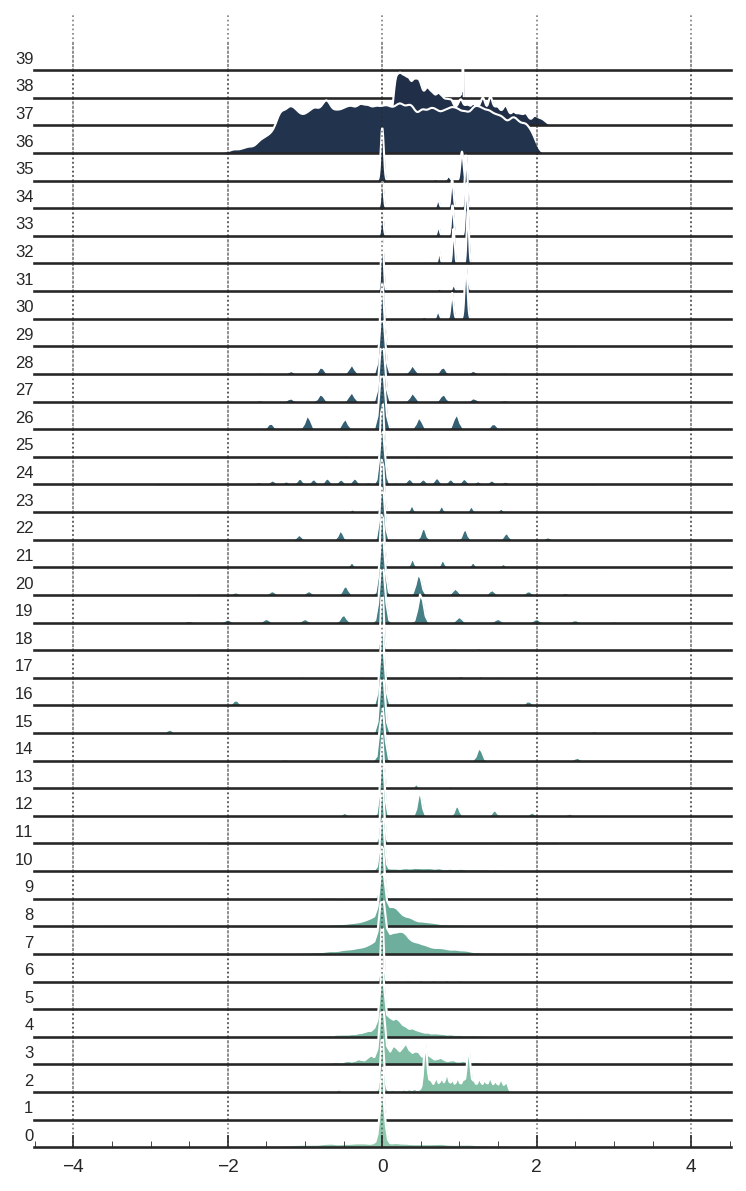

In [26]:
xx = extracted_normalization
ridgeplot()

[INFO    ] (min, max): -18.7718, 17.4017


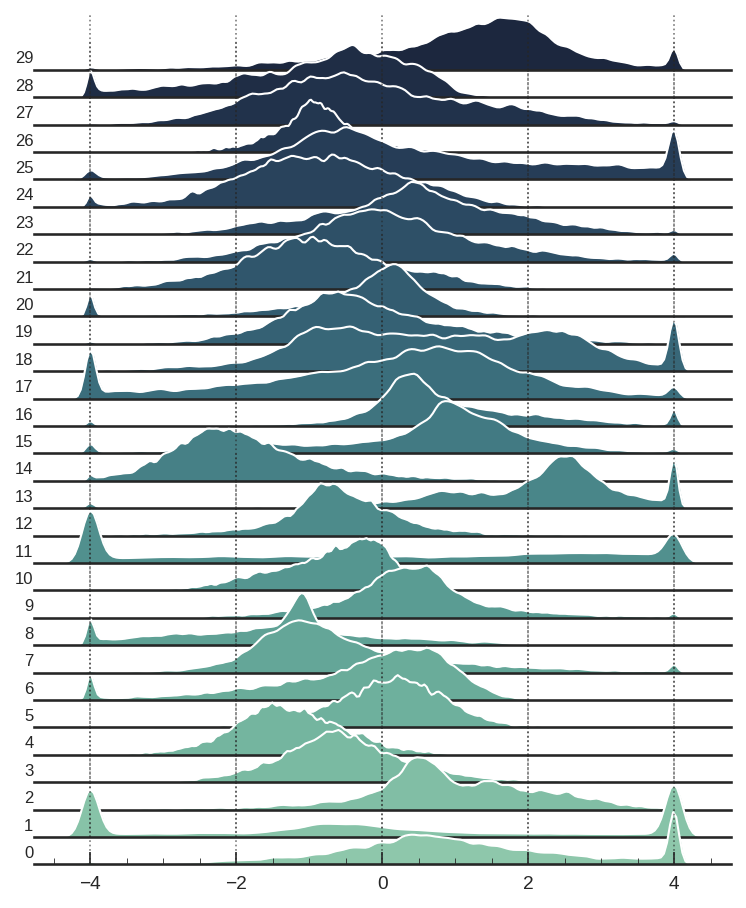

In [27]:
xx = extracted_batch_normalization
ridgeplot()

[INFO    ] (min, max): -12.6142, 12.1022


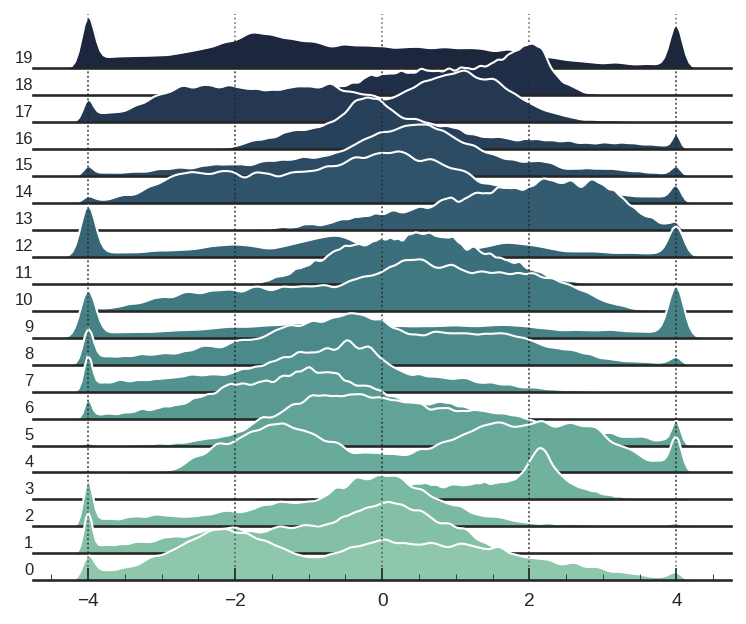

In [28]:
xx = extracted_batch_normalization_1
ridgeplot()

[INFO    ] (min, max): -5.0359, 4.9966


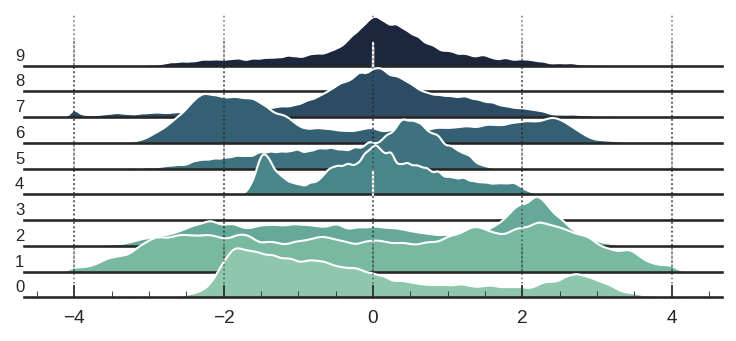

In [29]:
xx = extracted_batch_normalization_2
ridgeplot()

[INFO    ] loc (min, max): -0.5003 0.4816
[INFO    ] scale (min, max): 0.7313 0.7767


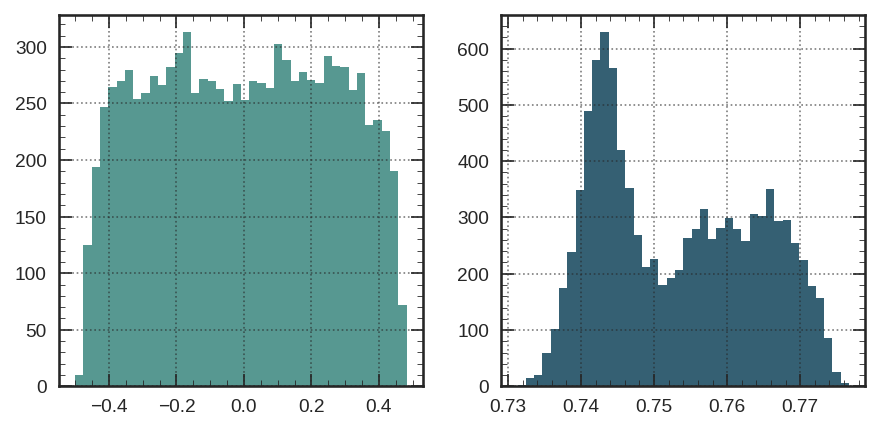

In [30]:
# Output layer
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)
pal = sns.cubehelix_palette(4, rot=-.4, light=.7)

xx = extracted_dense_3_loc
ax = axs[0]
ax.hist(xx, bins=40, color=pal[1])
logger.info('loc (min, max): {0:.4f} {1:.4f}'.format(*min_max(xx)))

xx = extracted_dense_3_scale
ax = axs[1]
ax.hist(xx, bins=40, color=pal[2])
logger.info('scale (min, max): {0:.4f} {1:.4f}'.format(*min_max(xx)))

plt.show()

[INFO    ] normalization (min, max): 0.9485, 2.7512
[INFO    ] batch_normalization (min, max): -1.9060, 5.1910
[INFO    ] batch_normalization_1 (min, max): -1.0937, 3.5199
[INFO    ] batch_normalization_2 (min, max): -0.4849, 2.0487
[INFO    ] dense (min, max): -2.2520, 2.1461
[INFO    ] dense_1 (min, max): -1.1653, 1.2523
[INFO    ] dense_2 (min, max): -0.8404, 1.0422
[INFO    ] dense_3_w (min, max): -0.1142, 0.2004
[INFO    ] dense_3_b (min, max): -0.0160, 0.7551


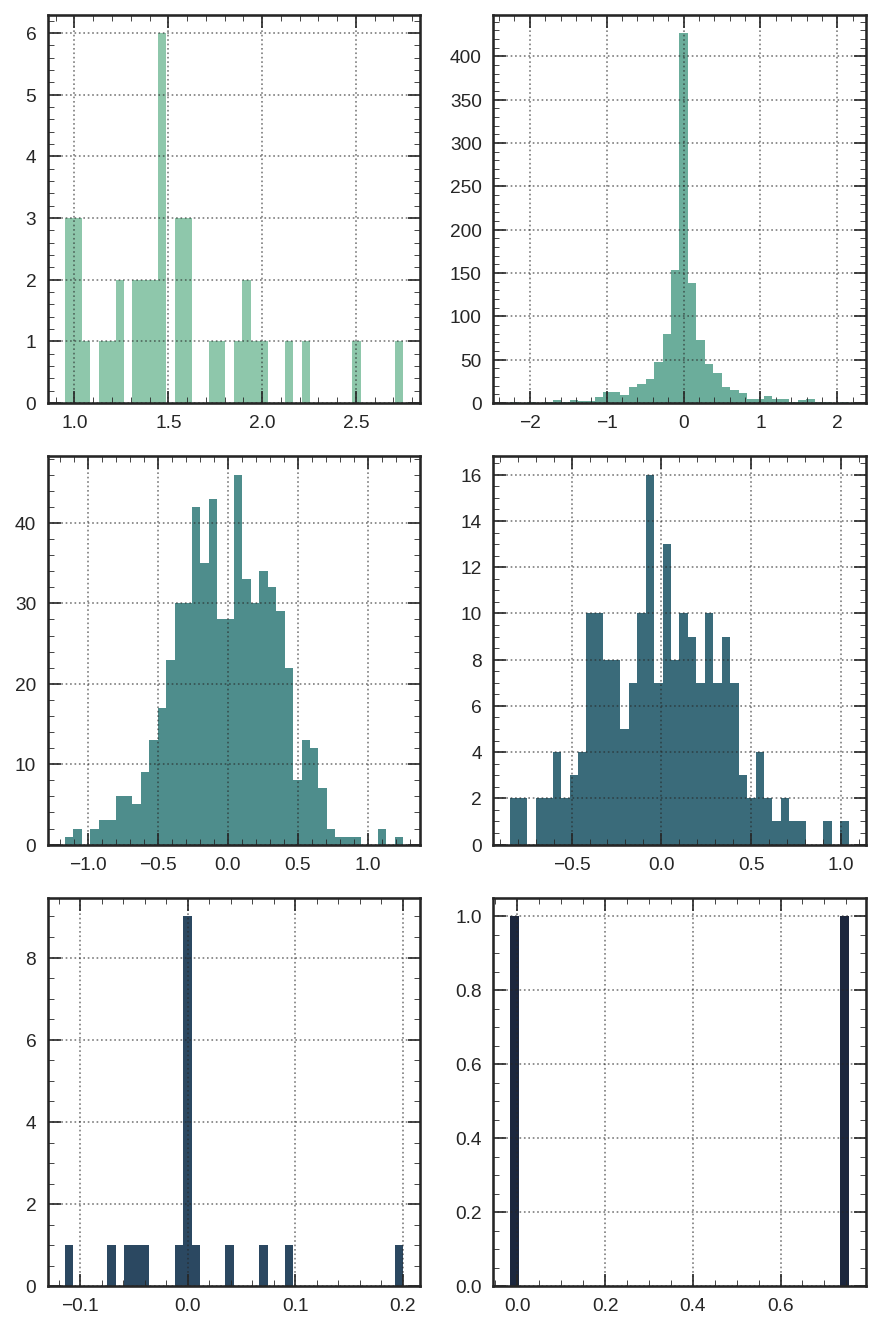

In [31]:
# Model weights
assert len(model.get_layer('dense').weights) == 1
assert len(model.get_layer('dense_1').weights) == 1
assert len(model.get_layer('dense_2').weights) == 1
assert len(model.get_layer('dense_3').weights) == 2
assert len(model.get_layer('normalization').weights) == 3
assert len(model.get_layer('batch_normalization').weights) == 4
assert len(model.get_layer('batch_normalization_1').weights) == 4
assert len(model.get_layer('batch_normalization_2').weights) == 4

fig, axs = plt.subplots(3, 2, figsize=(6,6/2*3), tight_layout=True)
pal = sns.cubehelix_palette(6, rot=-.4, light=.7)

xx = model.get_layer('normalization').weights[1].numpy()
xx = div_no_nan(1., np.sqrt(xx))
#xx = np.column_stack((xx, model.get_layer('normalization').weights[0].numpy() / xx))
ax = axs[0,0]
ax.hist(xx, bins=40, color=pal[0])
logger.info('normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
xx = np.column_stack((model.get_layer('batch_normalization').weights[0].numpy(), model.get_layer('batch_normalization').weights[1].numpy()))
logger.info('batch_normalization (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
xx = np.column_stack((model.get_layer('batch_normalization_1').weights[0].numpy(), model.get_layer('batch_normalization_1').weights[1].numpy()))
logger.info('batch_normalization_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
xx = np.column_stack((model.get_layer('batch_normalization_2').weights[0].numpy(), model.get_layer('batch_normalization_2').weights[1].numpy()))
logger.info('batch_normalization_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

xx = model.get_layer('dense').weights[0].numpy()
ax = axs[0,1]
ax.hist(xx.reshape(-1), bins=40, color=pal[1])
logger.info('dense (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
xx = model.get_layer('dense_1').weights[0].numpy()
ax = axs[1,0]
ax.hist(xx.reshape(-1), bins=40, color=pal[2])
logger.info('dense_1 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
xx = model.get_layer('dense_2').weights[0].numpy()
ax = axs[1,1]
ax.hist(xx.reshape(-1), bins=40, color=pal[3])
logger.info('dense_2 (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
xx = model.get_layer('dense_3').weights[0].numpy()
ax = axs[2,0]
ax.hist(xx.reshape(-1), bins=40, color=pal[4])
logger.info('dense_3_w (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))
xx = model.get_layer('dense_3').weights[1].numpy()
ax = axs[2,1]
ax.hist(xx.reshape(-1), bins=40, color=pal[5])
logger.info('dense_3_b (min, max): {0:.4f}, {1:.4f}'.format(*min_max(xx)))

plt.show()